# **Homework 2**
Brain-Inspired Computing <br>
Madhu Sivaraj (ms2407), Seth Karten (sak295), Alex Goodkind (amg540) <br>

 ## Problem 1: A basic SNN performing basic logic operations

Problem.And
Problem.Or
Problem.Xor
All tests passed successfully!


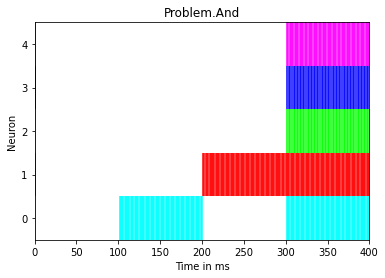

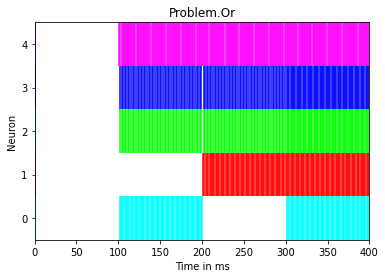

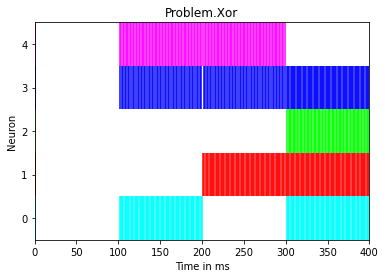

In [ ]:
from random import random
import numpy as np
import enum
import matplotlib.pyplot as plt
%matplotlib inline
class Problem(enum.Enum):
    And = 1
    Or = 2
    Xor = 3
    Mnist = 4

# model for boolean
class lif_model():
  def __init__ (self, R_m=1, C_m=10, threshold_voltage=1, delta=0.1, total_time=50):
    # Membrance resistance constant, Membrane Capacitance constant, Membrane voltage
    self.R_m=R_m
    self.C_m=C_m
    self.V = np.zeros((2+2+1))
    self.threshold_voltage=threshold_voltage
    self.delta=delta
    self.total_time=total_time
    self.W1 = np.zeros((2,2))
    self.W2 = np.zeros((2,1))
    self.lr = .1
    self.problem = Problem.And
    # self.problem = Problem.Or
    # self.problem = Problem.Xor
    
  def integrate_and_fire(self, j, input_current, state=False):
    # jth neuron of Membrane voltage (accessed in jth index)
    self.V[j] += 0.01*((-self.V[j]+self.R_m*input_current)/(self.R_m*self.C_m))
    if self.V[j] >= self.threshold_voltage:
        v = self.V[j]
        self.V[j] = 0 # reset node
        if state: return 1, v
        return 1   # high firing rate
    elif self.V[j] <= -self.threshold_voltage:
        self.V[j] = 0 # reset node
        if state: return 0, 0
        return 0
    else:
        if state: return 0, 0
        return 0    # low firing rate

  # weight update rule
  def hebbian_update(self, W, Vpre, Vpost):
    # standard hebb + decay + oja's rule + postsynaptic LTP/LTD threshold
    if Vpost == 0 and Vpre == 1: # if pre synaptic voltage is 1 and post-synaptic voltage is 0
      return self.lr * -.25 * Vpre - self.lr * W * .25**2 - self.lr/10.
    else: return self.lr * Vpost * Vpre - self.lr * W * Vpost*Vpost - self.lr/10.

  def hebbian_learning_l1(self, x, y, training=False, debug=False):
    f = np.zeros((2+2+1)) # firing rates
    self.V = np.zeros((2+2+1))
    # input layer forward
    for j, input in zip(range(0,2), [x,y]): # size of input layer
        f[j] = self.integrate_and_fire(j, input*2048)
    # hidden layer forward
    for j in range(2,4): # size of hidden layer
        input = f[0] * self.W1[0][j-2] + f[1] * self.W1[1][j-2]
        f[j] = self.integrate_and_fire(j, input*2048)
    V_post = f[2:4]
    # update weights
    asnwer = None
    if self.problem == Problem.And: answer = [int(x and y),int(x and y)]
    elif self.problem == Problem.Or: answer = [int(x or y),int(x or y)]
    elif self.problem == Problem.Xor: answer = [int(x and y),int(x or y)]
    else: raise ValueError("Invalid problem.")
    if training:
        if self.problem == Problem.And:
            f[2] = int(x and y)
            f[3] = int(x and y)
        elif self.problem == Problem.Or:
            f[2] = int(x or y)
            f[3] = int(x or y)
        elif self.problem == Problem.Xor:
            f[2] = int(x and y)
            f[3] = int(x or y)
        else: raise ValueError("Invalid problem.")
    for i in range(0,2): # pre synaptic connection - layer 0
        for j in range(2,4): # post synaptic connection
            self.W1[i][j-2] += self.hebbian_update(self.W1[i][j-2], f[i], f[j])
            self.W1[i][j-2] = min(1,self.W1[i][j-2])
            self.W1[i][j-2] = max(-1,self.W1[i][j-2])
    if debug: print(training, "x  y hidden_fired hidden_exp", x, y, V_post, answer)
    if debug: print("weights ", self.W1)
    if (answer == V_post).all(): 
        if debug: print("Correct\n")
        return True
    else:
        if debug: print("Wrong\n")
        return False

  def hebbian_learning_l2(self, x, y, training=False, debug=False):
    f = np.zeros((2+2+1)) # firing rates
    self.V = np.zeros((2+2+1))
    # input layer forward
    for j, input in zip(range(0,2), [x,y]): # size of input layer
        f[j] = self.integrate_and_fire(j, input*2048)
    # hidden layer forward
    for j in range(2,4): # size of hidden layer
        input = f[0] * self.W1[0][j-2] + f[1] * self.W1[1][j-2]
        f[j] = self.integrate_and_fire(j, input*2048)
    # output layer forward
    for j in range(4,5): # size of output layer
        input = f[2] * self.W2[0][j-4] + f[3] * self.W2[1][j-4]
        f[j] = self.integrate_and_fire(j, input*2048)
    V_post = int(f[4])
    # update weights
    answer = None
    if self.problem == Problem.And: answer = int(x and y)
    elif self.problem == Problem.Or: answer = int(x or y)
    elif self.problem == Problem.Xor: answer = int((x or y) and not (x and y))
    if training:
        if self.problem == Problem.And: f[4] = int(x and y)
        elif self.problem == Problem.Or: f[4] = int(x or y)
        elif self.problem == Problem.Xor: f[4] = int((x or y) and not (x and y))
        else: raise ValueError("Invalid problem.")
        for j in range(2,4): # update layer 1
            self.W2[j-2] += self.hebbian_update(self.W2[j-2], f[j], f[4])
            self.W2[j-2] = min(1,self.W2[j-2])
            self.W2[j-2] = max(-1,self.W2[j-2])
    if debug: print(training, "x  y answer predicted", x,y,answer, V_post, f)
    if debug: print("weights ",self.W1,self.W2)
    if answer == f[4]:
        if debug: print("Correct\n")
        return True
    else:
        if debug: print("Wrong\n")
        return False

  # determine jth neuron firing rate based on input_current
  def get_firing_rate(self, input_current, has_fired, tref=0.01):
    if has_fired:
        return 1./(tref - self.R_m * self.C_m * np.log(1 - (self.threshold_voltage / ((input_current) * self.R_m))))    # high firing rate
    else:
        return 0
model = lif_model()
spiking_data = np.zeros((3,4,5)) # # problems, # unique inputs, number of neurons
# tests each problem, throws error if prediction is wrong
for p_int, p in enumerate([Problem.And, Problem.Or, Problem.Xor]): 
    model.problem = p
    print(p)
    X = [0,1,0,1]
    Y = [0,0,1,1]
    epochs = 4*10
    for i in range(epochs): # train hidden layer
        x = X[i % 4]
        y = Y[i % 4]
        model.lr = 2/float(i+1) # decay learning rate over time
        if i < epochs-4: model.hebbian_learning_l1(x, y, training=True)
        else: 
            if not model.hebbian_learning_l1(x, y, debug=False): 
                raise ValueError("Error on layer 0",x,y)
    for i in range(epochs): # train output
        x = X[i % 4]
        y = Y[i % 4]
        model.lr = 2/float(i+1)
        if i < epochs-4: model.hebbian_learning_l2(x, y, training=True)
        else:
            if not model.hebbian_learning_l2(x,y, debug=False): 
                raise ValueError("Error on output",x,y)
    for x,y in zip(X,Y):
        model.lr = 2/float(i+1)
        if not model.hebbian_learning_l2(x,y, debug=False): 
            raise ValueError("Error on output",x,y)
    k = 0
    for x,y in zip(X,Y): # 1 problem per 100ms
        # let's compute firing rates
        # do forward computation
        f = np.zeros((2+2+1)) # firing rates per neuron
        f_b = np.zeros((2+2+1)) # binary fire
        model.V = np.zeros((2+2+1))
        # input layer forward
        for j, in1 in zip(range(0,2), [x,y]): # size of input layer
            f_b[j] = model.integrate_and_fire(j, in1*2048)
            f[j] = model.get_firing_rate(in1*2048, f_b[j])
        # hidden layer forward
        for j in range(2,4): # size of hidden layer
            input = f_b[0] * model.W1[0][j-2] + f_b[1] * model.W1[1][j-2]
            f_b[j] = model.integrate_and_fire(j, input*2048)
            f[j] = model.get_firing_rate(input*2048, f_b[j])
        # output layer forward
        for j in range(4,5): # size of output layer
            input = f_b[2] * model.W2[0][j-4] + f_b[3] * model.W2[1][j-4]
            f_b[j] = model.integrate_and_fire(j, input*2048)
            f[j] = model.get_firing_rate(input*2048, f_b[j])
        for i in range(5): # loop over neuron firing rates
            spiking_data[p_int][k][i] = f[i]
        k += 1
print("All tests passed successfully!")
# graph raster plot for all neurons
spiking_data[spiking_data==0] = .0000001
for problem_num, p in enumerate([Problem.And, Problem.Or, Problem.Xor]):
    spikes = np.zeros((5,4*1000))
    for i in range(4): # number of unique inputs
        rates = 1. / (spiking_data[problem_num,i]) * 100
        time_since_spike = np.zeros(5)
        t=0
        inc=.1
        while t < 100: # timestep is less than 100 ms
            for j in range(5):
                if rates[j] <= time_since_spike[j]:
                    spikes[j,i*1000+int(t*10)] = t+(i*100) # 1000 to ensure resolution is .0000001
                    time_since_spike[j] -= rates[j]
            time_since_spike += inc
            t+=inc
    colorCodes = np.array([[0, 1, 1],
                            [1, 0, 0],
                            [0, 1, 0],
                            [0, 0, 1],
                            [1, 0, 1]]
    )
    plt.eventplot(spikes, color=colorCodes)
    plt.xlim([0,400])
    plt.ylim([-.5,4.5])
    plt.title(p)
    plt.ylabel('Neuron')
    plt.xlabel('Time in ms')
    plt.show()

 ## Problem 2: An SNN tackling a real-world classification problem

### 2.2.1-2.2.3

We modified previously built single layer SNN to accommodate the digit dataset. We trained our SNN to classify handwritten digits, based on the following dataset:
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

In [ ]:
# all layers
# trying larger feature space - seth
from random import random
import numpy as np
import enum
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from pprint import pprint
class Problem(enum.Enum):
    And = 1
    Or = 2
    Xor = 3
    Mnist18 = 4
    Mnist38 = 5
    Mnist = 6

# model for mnist
class lif_model():
  def __init__ (self, epochs, R_m=1, C_m=10, threshold_voltage=1, delta=0.1, total_time=50):
    self.epochs=epochs
    self.R_m=R_m    # membrane resistance
    self.C_m=C_m    # membrane capacitance
    self.hsize = 18
    self.V = np.zeros((64+self.hsize+2)) # membrane voltage
    self.threshold_voltage=threshold_voltage
    # weights 1=between input and hidden layer
    #         2=between hidden and output layer
    self.W1 = np.zeros((2,2))
    self.W1_mnist = np.random.rand(64,self.hsize) * 2 - 1
    self.W2 = np.zeros((2,1))
    self.W2_mnist = np.zeros((self.hsize,2))
    self.lr = .1    # learning rate
    self.problem = Problem.Mnist18

  # determines if neuron will hit threshold and fire
  def integrate_and_fire(self, j, input_current):
    self.V[j] += 0.01*((-self.V[j]+self.R_m*input_current)/(self.R_m*self.C_m))
    if self.V[j] >= self.threshold_voltage:
        self.V[j] = 0 # reset node
        return 1    # high firing rate
    elif self.V[j] <= -self.threshold_voltage:
        self.V[j] = 0 # reset node
        return 0
    #     return -1
    else:
        return 0    # low firing rate

  # weight update rule
  def hebbian_update(self, W, Vpre, Vpost):
    # standard Hebb + decay + Oja + postsynaptic LTP/LTD threshold
    if Vpost == 0 and Vpre == 1: return self.lr * -1 * Vpre - self.lr * W * 1**2
    elif not self.problem==Problem.Mnist18 and Vpost == 1 and Vpre == 0: return self.lr * -1 * Vpre - self.lr * W * 1**2
    else: return self.lr * Vpost * Vpre - self.lr * W * Vpost - self.lr**2

  # trains both layers when training=True, else performs network inference
  def mnist(self,  X, label, epoch, training=False, debug=False, threshold=6):
    outputs = None
    if self.problem == Problem.Mnist18 or self.problem == Problem.Mnist38:
        outputs = 2
    elif self.problem == Problem.Mnist:
        outputs = 10
    if len(self.W2_mnist[0])!=outputs:
        self.W2_mnist = np.zeros((self.hsize,outputs))
    f = np.zeros((64+self.hsize+outputs)) # firing rates
    self.V = np.zeros((64+self.hsize+outputs))
    # input layer forward
    for j, input in zip(range(0,64), X): # size of input layer
        if input > threshold: input = 1
        else: input = 0
        f[j] = self.integrate_and_fire(j, input  * 2048)
    # hidden layer forward
    for j in range(64,64+self.hsize): # size of hidden layer
        input = 0
        for i in range(64):
            input += f[i] * self.W1_mnist[i][j-64]
        f[j] = self.integrate_and_fire(j, input*1024)
    # output forward
    V_outputs = []
    for j in range(64+self.hsize, 64+self.hsize+outputs): # size of output layer
        input = 0
        for i in range(64,64+self.hsize):
            input += f[i] * self.W2_mnist[i-64][j-64-self.hsize]
        V_outputs.append(input)
        if debug:
            print(j-64-self.hsize, input, f[64:64+self.hsize], self.W2_mnist)
        f[j] = self.integrate_and_fire(j, input*512)

    V_post = [0]*outputs
    V_post[np.argmax(V_outputs)] = 1
    if epoch < self.epochs:
        f[64:64+self.hsize] = 0
        # this precomputes where we expect the horizontal and vertical lines should be
        # email seth if you have questions
        if label == 0: f[64+np.array([0,2,6,8,9,10,11,12,14,15,16,17])] = 1
        elif label == 1: f[64+np.array([1,4,7,12])] = 1
        elif label == 2: f[64+np.array([0,2,4,6,9,10,11,13,15,16,17])] = 1
        elif label == 3: f[64+np.array([0,2,4,6,8,9,19,11,13,15,16,17])] = 1
        elif label == 4: f[64+np.array([1,3,4,7,10,12])] = 1
        elif label == 5: f[64+np.array([3,8,9,10,11,12,13,14,15,16,17])] = 1
        elif label == 6: f[64+np.array([0,3,5,6,8,9,10,11,13,14,15,16,17])] = 1
        elif label == 7: f[64+np.array([4,6,9,10,11,13,15])] = 1
        elif label == 8: f[64+np.array([0,2,4,6,8,9,10,11,13,15,16,17])] = 1
        elif label == 9: f[64+np.array([0,2,4,7,9,10])] = 1
    if self.problem == Problem.Mnist18:
        if label == 1:
            f[64+self.hsize] = 1
            f[64+self.hsize+1] = 0
        elif label == 8:
            f[64+self.hsize] = 0
            f[64+self.hsize+1] = 1
    elif self.problem == Problem.Mnist38:
        if label == 3:
            f[64+self.hsize] = 1
            f[64+self.hsize+1] = 0
        elif label == 8:
            f[64+self.hsize] = 0
            f[64+self.hsize+1] = 1
    elif self.problem == Problem.Mnist:
        f[64+self.hsize:64+self.hsize+outputs] = 0
        f[64+self.hsize+label] = 1
    # update weights
    if training:
        for i in range(0,64): # which input neuron (presynaptic)
            for j in range(64,64+self.hsize): # which hidden neuron (postsynaptic)
                self.W1_mnist[i][j-64] += self.hebbian_update(self.W1_mnist[i][j-64], f[i], f[j])
                self.W1_mnist[i][j-64] = min(1,self.W1_mnist[i][j-64])
                self.W1_mnist[i][j-64] = max(-1,self.W1_mnist[i][j-64])
        # output
        for i in range(64,64+self.hsize): # which input neuron (presynaptic)
            for j in range(64+self.hsize,64+self.hsize+outputs): # which hidden neuron (postsynaptic)
                self.W2_mnist[i-64][j-64-self.hsize] += self.hebbian_update(self.W2_mnist[i-64][j-64-self.hsize], f[i], f[j])
                self.W2_mnist[i-64][j-64-self.hsize] = min(1,self.W2_mnist[i-64][j-64-self.hsize])
                self.W2_mnist[i-64][j-64-self.hsize] = max(-1,self.W2_mnist[i-64][j-64-self.hsize])
    return (f[64+self.hsize:64+self.hsize+outputs] == V_post).all()

epochs=10
model = lif_model(epochs)
# model.problem = Problem.Mnist18 # 87.5% accuracy on test data observed
# model.problem = Problem.Mnist38 # 86% accuracy on test data observed
model.problem = Problem.Mnist # bruh
digits = load_digits()
images = digits.images
data = np.reshape(images, (len(images), -1))
data_orig = np.reshape(images, (len(images), -1))
labels_orig = digits.target
labels = digits.target
# split the dataset to train and test
model.lr = 1e-3
if model.problem == Problem.Mnist18:
    data=data[np.logical_or(labels_orig==1,labels_orig==8)]
    labels=labels_orig[np.logical_or(labels_orig==1,labels_orig==8)]
elif model.problem == Problem.Mnist38:
    data=data[np.logical_or(labels_orig==3,labels_orig==8)]
    labels=labels_orig[np.logical_or(labels_orig==3,labels_orig==8)]
else:
    model.lr = 1e-6
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
# np.random.seed(0)
training_data=[]
validation=[]
# training loop
for i in range(epochs):
    num_correct = 0
    j = 0
    shuffler = np.random.permutation(len(X_train))
    X_train = X_train[shuffler]
    y_train = y_train[shuffler]
    for x, y in zip(X_train, y_train):
        num_correct += model.mnist(x, y, i, training=True, debug=False)
        j += 1
    acc=num_correct/float(len(X_train))*100.
    print("H1 Train Epoch", i, "\tAccuracy:", acc)
    training_data.append(acc)
    # validation
    num_correct = 0
    for x, y in zip(X_val, y_val):
        num_correct += model.mnist(x, y, i)
    validation.append(num_correct/float(len(X_val))*100)
    print("H1 Val Epoch", i, "\tAccuracy:", num_correct/float(len(X_val))*100)

num_correct = 0
for x, y in zip(X_test, y_test):
    num_correct += model.mnist(x, y, i, training=True)
print("H1 Test Epoch", i, "\tAccuracy:", num_correct/float(len(y_test))*100)

H1 Train Epoch 0 	Accuracy: 9.051348999129678
H1 Val Epoch 0 	Accuracy: 15.972222222222221
H1 Train Epoch 1 	Accuracy: 11.923411662315056
H1 Val Epoch 1 	Accuracy: 15.972222222222221
H1 Train Epoch 2 	Accuracy: 14.360313315926893
H1 Val Epoch 2 	Accuracy: 15.972222222222221
H1 Train Epoch 3 	Accuracy: 14.186248912097476
H1 Val Epoch 3 	Accuracy: 15.972222222222221
H1 Train Epoch 4 	Accuracy: 14.186248912097476
H1 Val Epoch 4 	Accuracy: 15.972222222222221
H1 Train Epoch 5 	Accuracy: 14.186248912097476
H1 Val Epoch 5 	Accuracy: 15.972222222222221
H1 Train Epoch 6 	Accuracy: 13.92515230635335
H1 Val Epoch 6 	Accuracy: 15.972222222222221
H1 Train Epoch 7 	Accuracy: 13.838120104438643
H1 Val Epoch 7 	Accuracy: 15.972222222222221
H1 Train Epoch 8 	Accuracy: 14.099216710182768
H1 Val Epoch 8 	Accuracy: 16.319444444444446
H1 Train Epoch 9 	Accuracy: 14.273281114012185
H1 Val Epoch 9 	Accuracy: 16.319444444444446
H1 Test Epoch 9 	Accuracy: 15.555555555555555


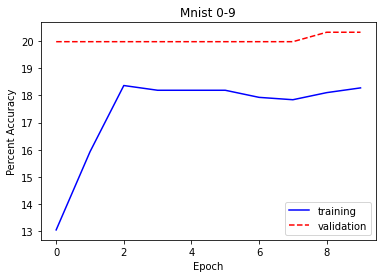

In [ ]:
training_data = np.array(training_data)
validation = np.array(validation)
plt.plot(range(epochs),training_data,color='blue',label="training")
plt.plot(range(epochs),validation,color='red',linestyle='--',label="validation")
plt.legend()
if Problem.Mnist18==model.problem: plt.title('Mnist 18')
elif Problem.Mnist38==model.problem: plt.title('Mnist 38')
elif Problem.Mnist==model.problem: plt.title('Mnist 0-9')
plt.ylabel('Percent Accuracy')
plt.xlabel('Epoch')
plt.show()
#mnist18 78% test accuracy
#mnist18 73% test accuracy
#mnist0-9 16% test accuracy